In [177]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.stats import f_oneway
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as mc
from scipy import stats

### 데이터 읽어오기

In [178]:
df = pd.read_excel("dataset_added.xlsx")

# 1. 수면 종합점수 sleep_score와 연관성이 가장 높은 항목 두 개를 추출하고, sleep_score를 설명하는 중요한 요인을 파악.

## 결과:
    sleep_score를 가장 잘 설명하는 두 개의 요인: 
        * sleep_total
        * sleep_efficiency

In [179]:
#sleep 관련 변수 필터링
sleep_cols = [col for col in df.columns if 'sleep_' in col.lower()]
sleep_data = df[sleep_cols]

In [180]:
#sleep 관련 각각 col들과 'sleep_score'와의 pearson correlation 구하기
tmp_sleep_data = sleep_data.drop('sleep_score_total', axis = 1, inplace = False)
corr_score_for_each_var = tmp_sleep_data.corr(method='pearson', numeric_only=True)['sleep_score']

#pearson correlation이 가장 높은 두 개의 col 구하기
top2_highest_corr = corr_score_for_each_var.drop('sleep_score').abs().nlargest(2)
var1 = top2_highest_corr.index[0]
var2 = top2_highest_corr.index[1]

#방금 구한 두 개의 col과 sleep_score와의 pearson correlation의 신뢰성 검정하기
data_clean = df.dropna(axis=0, how='any', inplace=False)

for x in top2_highest_corr.index:
    var, pvalue_var = pearsonr(data_clean[x], data_clean['sleep_score'])
    print(f'{x}의 pearson correlation은 {round(var, 4)}이고, p-value는 {round(pvalue_var, 4)}입니다.')
    if (pvalue_var < 0.05):
        print(f'{x}은 sleep_score와 유의미하게 상관성이 있습니다.')
    else:
        print(f'{x}은 sleep_score와 유의미하게 상관성이 있다고 볼 수 없습니다.')
    print('\n')

sleep_total의 pearson correlation은 0.7534이고, p-value는 0.0입니다.
sleep_total은 sleep_score와 유의미하게 상관성이 있습니다.


sleep_efficiency의 pearson correlation은 0.6219이고, p-value는 0.0입니다.
sleep_efficiency은 sleep_score와 유의미하게 상관성이 있습니다.




### 1.2 sleep_cols들과 sleep_score의 상관성을 시각화: png로 저장

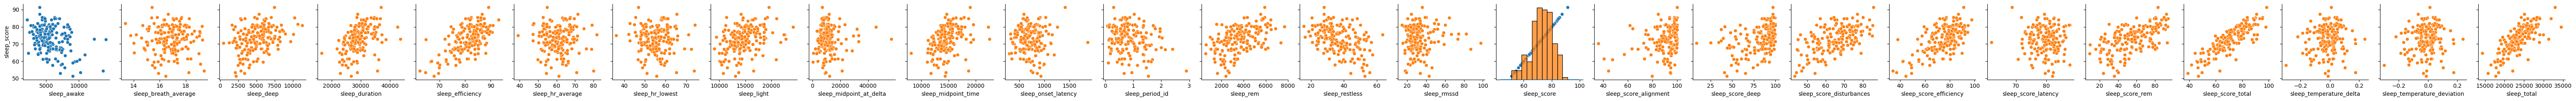

In [181]:
#sleep_cols들과 sleep_score의 상관성을 scatter plot으로 그린 결과
g = sns.pairplot(data=sleep_data, x_vars= sleep_cols, y_vars= ['sleep_score'], kind='scatter',diag_kind='kde', dropna=True)
g.map_upper(sns.scatterplot)
g.map_lower(sns.scatterplot)
g.map_diag(sns.histplot)

plt.savefig('sleep_cols_and_sleep_score.png')

# 2. ANOVA: CN, MCI, Dem 그룹의 sleep_score가 차이나는 지 검사
* H0: CN, MCI, Dem의 평균 수면 점수는 서로 동일하다 (치매 단계 간 수면 점수의 평균에 차이가 없다.)
* H1: CN, MCI, Dem 세 그룹 중 적어도 하나의 그룹의 수면 점수가 다른 그룹과 차이가 있다.
* alpha = 0.05

## 분석 결과:
    각 진단명 CN, MCI, Dem에서 sleep_score에 유의미한 차이가 없다.

### ANOVA TABLE

In [182]:
sleep_score_fit = smf.ols("sleep_score~C(DIAG_NM, Sum)", data = df).fit()
table = sm.stats.anova_lm(sleep_score_fit)
print(table)

alpha = 0.05
p_value = table['PR(>F)'].iloc[0]
if (p_value > alpha):
    print("\nH0를 기각하지 않습니다.\n수면시간은 각 진단명에 따른 차이가 없다고 볼 수 있습니다.")
else:
    print("\nH0를 기각합니다.\n수면시간은 각 진단명에 따라 차이가 있습니다.")

                    df       sum_sq    mean_sq       F    PR(>F)
C(DIAG_NM, Sum)    2.0    36.865094  18.432547  0.3169  0.728831
Residual         171.0  9946.256147  58.165241     NaN       NaN

H0를 기각하지 않습니다.
수면시간은 각 진단명에 따른 차이가 없다고 볼 수 있습니다.


### Mulicomparison table

In [183]:
comp = mc.MultiComparison(df['sleep_score'], df['DIAG_NM'])
compatible,_,_ = comp.allpairtest(stats.ttest_ind, method = 'bonf')
compatible

group1,group2,stat,pval,pval_corr,reject
CN,Dem,0.4222,0.6736,1.0,False
CN,MCI,0.743,0.4586,1.0,False
Dem,MCI,-0.025,0.9801,1.0,False


# 3. 피어슨의 상관계수 분석: sleep_score과 TOTAL

## 결과:
    correlation coefficient는 0.0254로, 약한 상관관계를 가지고 있지만,
    pvalue가 0.7395로, 통계적으로 유의미하지 않음.

### Pearson Correlation between sleep_score and TOTAL

The correlation coefficient is  0.0254
p value is 0.7395


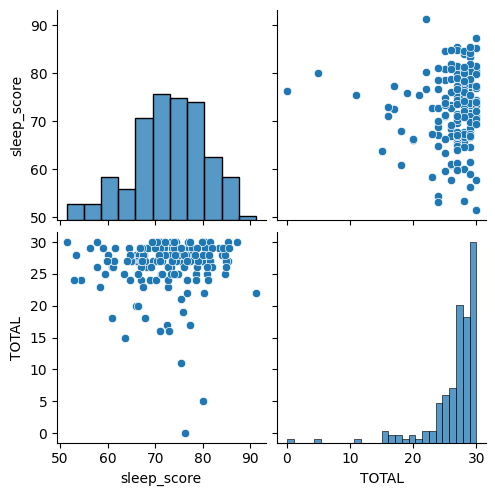

In [212]:
sns.pairplot(data = df, vars = ['sleep_score', 'TOTAL'], kind = 'scatter',dropna=True)

data_clean = df.dropna(axis = 0, how = 'any', inplace=False)
r2, p_value = pearsonr(data_clean['sleep_score'], data_clean['TOTAL'])

print('The correlation coefficient is ', np.round(r2, 4))
print('p value is', np.round(p_value, 4))

# 4. OrderedLogstic regression: between sleep factors and DIAG_NM

## 결과:
    summary 해석을 못 하겠음.

### Probit ordinal regression

In [185]:
from statsmodels.miscmodels.ordinal_model import OrderedModel

# 독립변수와 종속변수
X = sleep_data

df['DIAG_NM'] = pd.Categorical(df['DIAG_NM'], categories=['CN', 'MCI', 'Dem'], ordered=True)
y = df['DIAG_NM']

#sleep 관련 속성들과 DIAG_NM만 모아놓은 DataFrame
new_df = pd.concat([X, y], axis=1)

sleep_columns = X.columns

mod_prob = OrderedModel(new_df['DIAG_NM'],
                        new_df[sleep_columns],
                        distr='probit')

res_prob = mod_prob.fit(method='bfgs')
res_prob.summary()

         Current function value: 0.718169
         Iterations: 22
         Function evaluations: 80
         Gradient evaluations: 68


/Users/raewookang/Library/Python/3.9/lib/python/site-packages/scipy/optimize/_optimize.py:1292: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)
/Users/raewookang/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                DIAG_NM   Log-Likelihood:                -124.96
Model:                   OrderedModel   AIC:                             305.9
Method:            Maximum Likelihood   BIC:                             394.4
Date:                Tue, 03 Dec 2024                                         
Time:                        20:05:20                                         
No. Observations:                 174                                         
Df Residuals:                     146                                         
Df Model:                          26                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
sleep_awake                     0.0951      0.002     47.851      0.000       0.091       0.099
sleep_breath_average            0.1239      0.106      1.174      0.240      -0.083       0.331
sleep_deep                      0.0735      0.003     27.391      0.000       0.068       0.079
sleep_duration                 -0.0950      0.002    -47.843      0.000      -0.099      -0.091
sleep_efficiency               -0.0177      0.500     -0.035      0.972      -0.997       0.962
sleep_hr_average                0.0327      0.088      0.372      0.710      -0.140       0.205
sleep_hr_lowest                -0.0583      0.101     -0.578      0.563      -0.256       0.140
sleep_light                     0.0737      0.003     27.622      0.000       0.068       0.079
sleep_midpoint_at_delta     -3.574e-06   2.02e-05     -0.177      0.859   -4.31e-05    3.59e-05
sleep_midpoint_time            -0.0004      0.000     -1.060      0.289      -0.001       0.000
sleep_onset_latency             0.0003      0.001      0.437      0.662      -0.001       0.001
sleep_period_id                -0.0773      0.218     -0.354      0.723      -0.505       0.350
sleep_rem                       0.0739      0.003     27.525      0.000       0.069       0.079
sleep_restless                  0.0359      0.030      1.210      0.226      -0.022       0.094
sleep_rmssd                    -0.0111      0.011     -1.052      0.293      -0.032       0.010
sleep_score                     0.0105      2.871      0.004      0.997      -5.616       5.637
sleep_score_alignment           0.0166      0.288      0.058      0.954      -0.547       0.581
sleep_score_deep               -0.0013      0.289     -0.005      0.996      -0.568       0.565
sleep_score_disturbances        0.0537      0.435      0.123      0.902      -0.799       0.907
sleep_score_efficiency         -0.0362      0.383     -0.095      0.925      -0.787       0.714
sleep_score_latency            -0.0530      0.290     -0.182      0.855      -0.622       0.516
sleep_score_rem                -0.0339      0.290     -0.117      0.907      -0.603       0.535
sleep_score_total              -0.0079      1.002     -0.008      0.994      -1.972       1.956
sleep_temperature_delta        -0.0152     48.315     -0.000      1.000     -94.710      94.680
sleep_temperature_deviation    -0.0152     48.272     -0.000      1.000     -94.626      94.596
sleep_total                     0.0216      0.005      4.762      0.000       0.013       0.031
CN/MCI                          0.3555     24.515      0.015      0.988     -47.693      48.404
MCI/Dem                         0.3659      0.131      2.783      0.005       0.108       0.624
===============================================================================================
"""

### Logit ordinal regression

In [186]:
mod_logit = OrderedModel(new_df['DIAG_NM'],
                        new_df[sleep_columns],
                        distr='logit')

res_logit = mod_logit.fit(method='bfgs', disp=False)
res_logit.summary()

/Users/raewookang/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                DIAG_NM   Log-Likelihood:                -126.13
Model:                   OrderedModel   AIC:                             308.3
Method:            Maximum Likelihood   BIC:                             396.7
Date:                Tue, 03 Dec 2024                                         
Time:                        20:05:20                                         
No. Observations:                 174                                         
Df Residuals:                     146                                         
Df Model:                          26                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
sleep_awake                     0.0973      0.008     12.651      0.000       0.082       0.112
sleep_breath_average            0.2248      0.203      1.106      0.269      -0.174       0.623
sleep_deep                      0.0741      0.011      6.856      0.000       0.053       0.095
sleep_duration                 -0.0970      0.008    -12.032      0.000      -0.113      -0.081
sleep_efficiency                0.0026      0.895      0.003      0.998      -1.751       1.756
sleep_hr_average                0.0674      0.153      0.440      0.660      -0.233       0.368
sleep_hr_lowest                -0.1161      0.177     -0.654      0.513      -0.464       0.232
sleep_light                     0.0744      0.011      6.926      0.000       0.053       0.095
sleep_midpoint_at_delta     -5.165e-06   3.64e-05     -0.142      0.887   -7.66e-05    6.63e-05
sleep_midpoint_time            -0.0007      0.001     -1.084      0.278      -0.002       0.001
sleep_onset_latency             0.0004      0.001      0.379      0.705      -0.002       0.002
sleep_period_id                -0.1204      0.378     -0.318      0.750      -0.862       0.621
sleep_rem                       0.0745      0.011      6.899      0.000       0.053       0.096
sleep_restless                  0.0545      0.052      1.053      0.292      -0.047       0.156
sleep_rmssd                    -0.0164      0.018     -0.922      0.356      -0.051       0.018
sleep_score                     0.0099      4.902      0.002      0.998      -9.598       9.618
sleep_score_alignment           0.0261      0.492      0.053      0.958      -0.937       0.989
sleep_score_deep               -0.0020      0.494     -0.004      0.997      -0.970       0.966
sleep_score_disturbances        0.0849      0.744      0.114      0.909      -1.374       1.544
sleep_score_efficiency         -0.0813      0.647     -0.126      0.900      -1.350       1.187
sleep_score_latency            -0.0927      0.497     -0.186      0.852      -1.067       0.881
sleep_score_rem                -0.0487      0.493     -0.099      0.921      -1.015       0.917
sleep_score_total              -0.0176      1.713     -0.010      0.992      -3.374       3.339
sleep_temperature_delta        -0.0298     72.394     -0.000      1.000    -141.919     141.860
sleep_temperature_deviation    -0.0298     72.464     -0.000      1.000    -142.057     141.997
sleep_total                     0.0233      0.019      1.238      0.216      -0.014       0.060
CN/MCI                          0.5693     44.577      0.013      0.990     -86.801      87.940
MCI/Dem                         0.8923      0.149      5.970      0.000       0.599       1.185
===============================================================================================
"""

# 5. Binary Logistic regression : between sleep factors and CN / non-CN

## 결과:
    모델 학습이 형편없게 됨. 
    아마 sleep factors들과 DIAG_NM과의 직접적인 상관성이 없기 때문으로 추정

### 데이터 전처리
* sleep 관련 속성들과 DIAG_NM의 속성을 CN: 0, non-CN: 1로 치환하여 dataframe 생성

In [226]:
data = pd.read_excel("dataset_added.xlsx")
from imblearn.over_sampling import SMOTE
from collections import Counter

x_bin = sleep_data

mapping = {'CN': 0, 'MCI': 1, 'Dem': 1}
df['DIAG_NM_numeric'] = df['DIAG_NM'].map(mapping)
y_bin = df['DIAG_NM_numeric']
print(y_bin)

# 오버샘플링 수행
smote = SMOTE(random_state=42)
x_res, y_res = smote.fit_resample(x_bin, y_bin)

# NumPy 배열로 반환된 결과를 DataFrame으로 변환 (X_train이 DataFrame일 때)
if isinstance(x_bin, pd.DataFrame):
    X_res = pd.DataFrame(x_res, columns=x_bin.columns)
    y_res = pd.Series(y_res, name=y_bin.name)

# 클래스 비율 확인
print("Resampled class distribution with SMOTE:", Counter(y_res))

# Resampled 데이터를 DataFrame으로 변환
smote_df = pd.DataFrame(x_res, columns=x_bin.columns)
smote_df['DIAG_NM_numeric'] = y_res

print(smote_df.head())  # SMOTE로 생성된 데이터 확인

#new_df_bin = pd.concat([x_bin, y_bin], axis=1)


0      1
1      0
2      1
3      1
4      1
      ..
169    0
170    0
171    0
172    1
173    0
Name: DIAG_NM_numeric, Length: 174, dtype: int64
Resampled class distribution with SMOTE: Counter({1: 111, 0: 111})
   sleep_awake  sleep_breath_average  sleep_deep  sleep_duration  \
0   7162.85714              16.45437  4302.85714     30706.66667   
1   2055.66372              16.30752  6152.12389     30115.75221   
2   7252.24138              16.89224  3081.72414     27499.65517   
3   3436.47541              17.29201  7519.18033     26599.67213   
4   6641.91176              14.86949  4346.91176     28521.17647   

   sleep_efficiency  sleep_hr_average  sleep_hr_lowest  sleep_light  \
0          77.12698          57.95794         52.15873  15489.04762   
1          93.07080          65.23195         57.83186  16303.53982   
2          74.06897          53.17534         46.98276  12873.10345   
3          87.24590          51.67164         47.95082  13198.52459   
4          77.76471  

### test-set, train-set 분리

In [227]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(smote_df[x_bin.columns], 
                                                    smote_df['DIAG_NM_numeric'], 
                                                    test_size=0.2, 
                                                    shuffle=True, 
                                                    stratify=smote_df['DIAG_NM_numeric'])

print("The dimension of the trainset is ", x_train.shape)
print("The dimension of the testset is ", x_test.shape)
print(y_train.value_counts(normalize=True))

The dimension of the trainset is  (177, 26)
The dimension of the testset is  (45, 26)
DIAG_NM_numeric
1    0.502825
0    0.497175
Name: proportion, dtype: float64


In [228]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder

scaler = StandardScaler()
xtrain_scaled = scaler.fit_transform(x_train)
xtest_scaled = scaler.fit_transform(x_test)

### Training with Logistic regression

In [236]:
from sklearn.linear_model import LogisticRegression

model1 = LogisticRegression(tol=1e-08).fit(xtrain_scaled, y_train)
coef = {}
i = 0
for col in x_bin.columns:
    coef.setdefault(col,model1.coef_[0][i])
    i += 1
print("_____________________________________________")
print("regression coefficients are ", coef)
print("inpercept is ", model1.intercept_)
print("model score is ", model1.score(xtrain_scaled, y_train))
print("_____________________________________________")

_____________________________________________
regression coefficients are  {'sleep_awake': np.float64(0.3014224139531471), 'sleep_breath_average': np.float64(0.16727457400401083), 'sleep_deep': np.float64(-0.27162656888632614), 'sleep_duration': np.float64(0.38650527852431854), 'sleep_efficiency': np.float64(-0.17593952337195054), 'sleep_hr_average': np.float64(-0.09937137273785294), 'sleep_hr_lowest': np.float64(-0.154879424450138), 'sleep_light': np.float64(0.5956215089841345), 'sleep_midpoint_at_delta': np.float64(-0.0745963333613048), 'sleep_midpoint_time': np.float64(-0.4338689951360752), 'sleep_onset_latency': np.float64(-0.1568552011841411), 'sleep_period_id': np.float64(-0.14114998866320036), 'sleep_rem': np.float64(-0.17537552474249035), 'sleep_restless': np.float64(-0.012603257791953077), 'sleep_rmssd': np.float64(-0.30543896343566895), 'sleep_score': np.float64(-0.07960165692374427), 'sleep_score_alignment': np.float64(0.2927128427407278), 'sleep_score_deep': np.float64(-0.0

### Using StatsModel, Training with Logistic regression

In [239]:
X = sm.add_constant(x_train)

# 모델 학습
model = sm.Logit(y_train, X)  # 로지스틱 회귀 모델
result = model.fit()

# 회귀계수와 p-value 출력
print(result.summary())

         Current function value: 0.598196
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:        DIAG_NM_numeric   No. Observations:                  177
Model:                          Logit   Df Residuals:                      151
Method:                           MLE   Df Model:                           25
Date:                Tue, 03 Dec 2024   Pseudo R-squ.:                  0.1370
Time:                        23:15:54   Log-Likelihood:                -105.88
converged:                      False   LL-Null:                       -122.68
Covariance Type:            nonrobust   LLR p-value:                    0.1166
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                         -11.6574     52.502     -0.222      0.824    -114.560      91.245
sleep_awake   

/Users/raewookang/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### Predict probability

### Predict DIAG_NM

In [231]:
y_pred = model1.predict(xtest_scaled)
print("predicted DIAG_NMs are ", y_pred)

predicted DIAG_NMs are  [0 0 1 0 0 1 0 0 0 1 1 0 0 0 1 0 1 1 0 1 0 1 1 1 0 1 0 0 1 0 1 0 1 1 1 0 1
 1 0 1 1 0 1 1 0]


In [232]:
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[14  9]
 [ 8 14]]


### Performance evaluation

In [233]:
print(metrics.classification_report(y_test, y_pred, target_names=['CN', 'non-CN']))

              precision    recall  f1-score   support

          CN       0.64      0.61      0.62        23
      non-CN       0.61      0.64      0.62        22

    accuracy                           0.62        45
   macro avg       0.62      0.62      0.62        45
weighted avg       0.62      0.62      0.62        45



# 6. Sleep factor들과 DIAG_NM(CN, MCI, Dem)의 Multi Logistic Regression 진행

In [195]:
data = pd.read_excel("dataset_added.xlsx")

x_bin = sleep_data

y_bin = df['DIAG_NM']

new_df_bin = pd.concat([x_bin, y_bin], axis=1)

In [196]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(new_df_bin[x_bin.columns], new_df_bin['DIAG_NM'], test_size=0.2, shuffle=True, stratify=new_df_bin['DIAG_NM'])

print("The dimension of the trainset is ", x_train.shape)
print("The dimension of the testset is ", x_test.shape)

The dimension of the trainset is  (139, 26)
The dimension of the testset is  (35, 26)


In [197]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder

scaler = StandardScaler()
xtrain_scaled = scaler.fit_transform(x_train)
xtest_scaled = scaler.fit_transform(x_test)

In [198]:
from sklearn.linear_model import LogisticRegression

model1 = LogisticRegression(multi_class="multinomial", tol=1e-08).fit(xtrain_scaled, y_train)
print("_____________________________________________")
print("regression coefficients are ", model1.coef_)
print("inpercept is ", model1.intercept_)
print("model score is ", model1.score(xtrain_scaled, y_train))
print("_____________________________________________")

_____________________________________________
regression coefficients are  [[-0.00446952 -0.28325281 -0.00654728 -0.19909749  0.14414749  0.01141713
   0.20764992 -0.19871812  0.3549619  -0.11016647 -0.17802675  0.20484671
  -0.13368958 -0.18917391  0.16993034  0.18378952 -0.03855045  0.26389271
  -0.19779328  0.2490265   0.11926738  0.31835772  0.12198496  0.01956968
   0.01956968 -0.23105025]
 [ 0.24909468  0.20941106  0.15859788  0.34212535 -0.1492153   0.11205898
  -0.21347697  0.14150777 -0.64733769  0.11829455  0.66458633 -0.35090663
   0.10977871  0.68244766 -0.44901603 -0.16458041 -0.64492521 -0.0303321
   0.2455105  -0.12068084 -0.64950431 -0.138607   -0.09791072 -0.108819
  -0.108819    0.26455705]
 [-0.24462515  0.07384175 -0.1520506  -0.14302786  0.00506781 -0.12347611
   0.00582705  0.05721035  0.29237579 -0.00812809 -0.48655958  0.14605993
   0.02391087 -0.49327375  0.27908569 -0.01920911  0.68347566 -0.23356061
  -0.04771722 -0.12834565  0.53023693 -0.17975073 -0.0240742

/Users/raewookang/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/raewookang/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [199]:
y_pred = model1.predict(xtest_scaled)
print("predicted DIAG_NMs are ", y_pred)

predicted DIAG_NMs are  ['CN' 'CN' 'CN' 'CN' 'CN' 'CN' 'CN' 'CN' 'CN' 'CN' 'Dem' 'CN' 'CN' 'CN'
 'CN' 'CN' 'CN' 'CN' 'CN' 'CN' 'Dem' 'CN' 'MCI' 'CN' 'CN' 'CN' 'MCI' 'CN'
 'MCI' 'MCI' 'CN' 'CN' 'CN' 'CN' 'CN']


In [200]:
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[18  1  3]
 [ 3  0  0]
 [ 8  1  1]]


In [201]:
print(metrics.classification_report(y_test, y_pred, target_names=['CN', 'MCI', 'Dem']))

              precision    recall  f1-score   support

          CN       0.62      0.82      0.71        22
         MCI       0.00      0.00      0.00         3
         Dem       0.25      0.10      0.14        10

    accuracy                           0.54        35
   macro avg       0.29      0.31      0.28        35
weighted avg       0.46      0.54      0.48        35



# Pearson correlation between every Sleep datas and TOTAL

# 위에서 진행한 일련의 분석 결과, Sleep 속성들과 DIAG_NM간에는 직접적인 상관성이 없다고 결론지을 수 있다.
    그렇다면, 간접적으로는 영향이 있지 않을까?

## 1. DIAG_NM과 TOTAL간의 ANOVA를 진행
    -> 진단명 그룹 간에 인지기능 검사 총 점수의 유의미한 차이가 있는 지 검사한다. 
    
## 2. Sleep 관련 속성들과 TOTAL의 상관계수를 구하고, 다중회귀분석 실시
    -> TOTAL과 선형적 연광성이 있는 sleep 속성들을 구해낼 수 있다.

## 3. 1과 2를 연관짓는다.
    그러면, sleep 관련 속성들과 TOTAL의 연관성을 증명해내면 수면의 질이 치매 진단에 간접적으로 영향이 있다고 해석할 수 있지 않을까?

# 결론:
    1. 각 진단명 그룹 간에 인지기능 검사 총 점수에서 유의미한 차이가 발견되었다.
    2. sleep_midpoint_time과 sleep_onset_latency가 인지기능 검사 총 점수와 유의미한 선형적 상관성을 보인다.
    3. sleep_midpoint_time과 sleep_onset_latency가 인지기능 검사 총 점수에 유의미한 영향을 미치고, 인지기능 총 점수는 진단명에 유의미한 영향을 미친다.

# ANOVA: DIAG_NM and TOTAL

In [202]:
total_fit = smf.ols("TOTAL~C(DIAG_NM, Sum)", data = df).fit()
table = sm.stats.anova_lm(total_fit)
print(table)

alpha = 0.05
p_value = table['PR(>F)'].iloc[0]
if (p_value > alpha):
    print("\nH0를 기각하지 않습니다.\n인지기능 총 점수는 각 진단명에 따른 차이가 없다고 볼 수 있습니다.")
else:
    print("\nH0를 기각합니다.\n인지기능 총 점수는 각 진단명에 따라 차이가 있습니다.")

                    df       sum_sq     mean_sq          F        PR(>F)
C(DIAG_NM, Sum)    2.0  1361.683529  680.841764  73.060969  1.164984e-23
Residual         171.0  1593.517621    9.318816        NaN           NaN

H0를 기각합니다.
인지기능 총 점수는 각 진단명에 따라 차이가 있습니다.


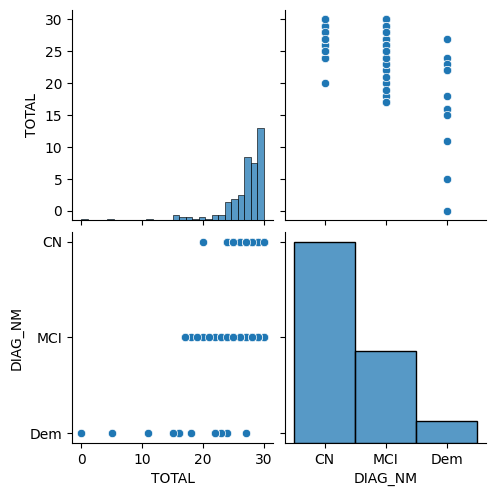

In [203]:
sns.pairplot(data = df, vars = ['TOTAL', 'DIAG_NM'], kind = 'scatter',dropna=True)

# ALL PAIR TEST: 어느 그룹에서 차이가 날까?

In [204]:
comp = mc.MultiComparison(df['TOTAL'], df['DIAG_NM'])
compatible,_,_ = comp.allpairtest(stats.ttest_ind, method = "bonf")
compatible

group1,group2,stat,pval,pval_corr,reject
CN,Dem,12.3856,0.0,0.0,True
CN,MCI,4.7244,0.0,0.0,True
Dem,MCI,-6.3714,0.0,0.0,True


# ANOVA 및 ALL PAIR TEST 결론
  * CN - Dem : TOTAL 유의미하게 차이남.
  * CN - MCI : TOTAL 유의미하게 차이남. 
  * Dem - MCI : TOTAL 유의미하게 차이남.

## -> 그렇다면, TOTAL에 가장 큰 영향을 주는 sleep 속성들은 무엇일까? 
  * 피어슨의 상관계수를 사용해서 상관성이 있는 속성들을 추려보자  

# Pearson correlation between every Sleep datas and TOTAL

### 1. 데이터 전처리

In [205]:
x = sleep_data
y = df['TOTAL']

new_df = pd.concat([x, y], axis=1)
data_cleaned = new_df.dropna(axis = 0, how = 'any', inplace = False)

### 2. sleep 관련 속성들과 TOTAL간에 상관성이 있다고 볼 수 있는 속성들 추려내기

In [206]:
correlation_cols = []
correlation_cols_info = []

for col in sleep_cols:
    r2, pvalue = pearsonr(data_cleaned[col], data_cleaned['TOTAL'])  
    if (pvalue < 0.05 and np.abs(r2) > 0.2):
        correlation_cols_info.append((col, r2, pvalue))
        correlation_cols.append(col)

correlation_cols_info
correlation_cols

['sleep_awake',
 'sleep_duration',
 'sleep_light',
 'sleep_midpoint_time',
 'sleep_onset_latency',
 'sleep_restless',
 'sleep_total']

# 피어슨의 상관계수 결과:
* 유의미한 상관계수를 가지고있는 속성들
    * sleep_awake
    * sleep_duration    
    * sleep_light
    * sleep_midpoint_time
    * sleep_onset_latency
    * sleep_restless
    * sleep_total

## -> 그렇다면 이제 위의 속성들을 대상으로 TOTAL과 다중 회귀분석을 실시해보자

### 1. 다중회귀분석 결과

In [207]:
added_X = sm.add_constant(new_df[correlation_cols])
ols_fitted = sm.OLS(data_cleaned['TOTAL'], added_X).fit()

print(ols_fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                  TOTAL   R-squared:                       0.185
Model:                            OLS   Adj. R-squared:                  0.151
Method:                 Least Squares   F-statistic:                     5.390
Date:                Tue, 03 Dec 2024   Prob (F-statistic):           1.39e-05
Time:                        20:05:21   Log-Likelihood:                -475.48
No. Observations:                 174   AIC:                             967.0
Df Residuals:                     166   BIC:                             992.2
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  36.3816    

### 2. pvalue < 0.05인 col인, sleep_midpoint_time과 sleep_onset_latency만 따로 회귀선 시각화

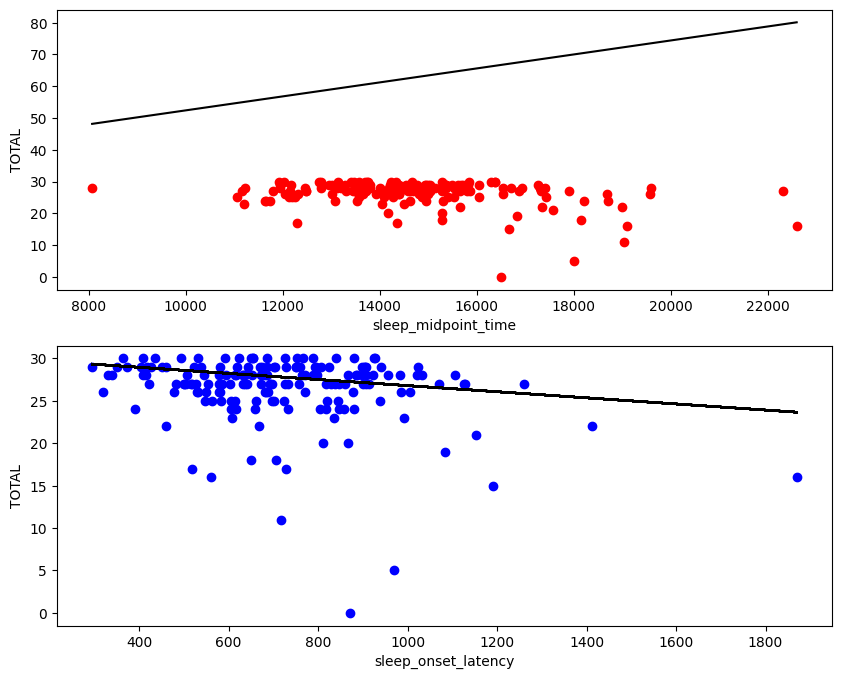

In [208]:
x1 = np.linspace(data_cleaned['sleep_midpoint_time'].min(), data_cleaned['sleep_midpoint_time'].max(), 100, endpoint=True)
x2 = np.linspace(data_cleaned['sleep_onset_latency'].min(), data_cleaned['sleep_onset_latency'].max(), 100, endpoint=True)

X1, X2 = np.meshgrid(x1, x2)

Y1 = 30.3816 + 0.0022 * X1
Y2 = 30.3816 + (-0.0036) * X2

fig = plt.figure(figsize=(10,8))

# 첫 번째 서브플롯 (RAD와 TAX 관계)
ax1 = fig.add_subplot(211)
ax1.scatter(data_cleaned['sleep_midpoint_time'], data_cleaned['TOTAL'], color='red')  # 데이터 산점도
ax1.plot(x1, Y1[0, :], color='black')  # 회귀선 (X1에 대한 Y1 값을 그리도록 수정)

# 두 번째 서브플롯 (TRACT와 TAX 관계)
ax2 = fig.add_subplot(212)
ax2.scatter(data_clean['sleep_onset_latency'], data_clean['TOTAL'], color='blue')  # 데이터 산점도
ax2.plot(x2, Y2, color='black')  # 회귀선 (X2에 대한 Y2 값을 그리도록 수정)

ax1.set_xlabel('sleep_midpoint_time')
ax1.set_ylabel('TOTAL')
ax2.set_xlabel('sleep_onset_latency')
ax2.set_ylabel('TOTAL')

plt.show()

### 3. sleep_midpoint_time과 sleep_onset_latency를 같이 고려하여 'TOTAL'과 다중 회귀선으로 시각화

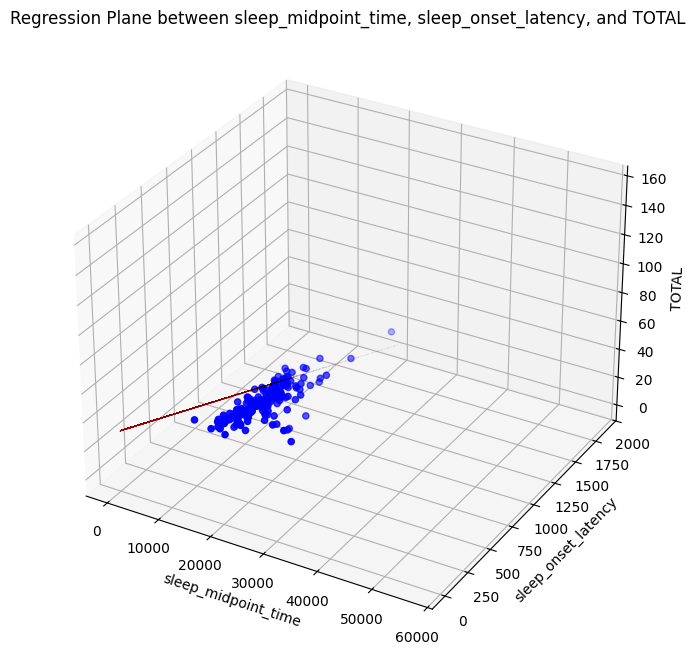

In [209]:
# 'RAD'와 'TRACT' 값의 범위 설정
x1 = np.linspace(data_cleaned['sleep_midpoint_time'].min(), data_cleaned['sleep_midpoint_time'].max(), 100, endpoint=True)
x2 = np.linspace(data_cleaned['sleep_onset_latency'].min(), data_cleaned['sleep_onset_latency'].max(), 100, endpoint=True)

# 그리드 생성
X, Y = np.meshgrid(x, y)

# 회귀식
Z = 30.3816 + 0.0022 * X + (-0.0036) * Y

# 3D 그래프 생성
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection = '3d')

# scatter plot 
ax.scatter(data_cleaned['sleep_midpoint_time'], data_cleaned['sleep_onset_latency'], data_cleaned['TOTAL'], color='blue')

# 회귀면 그리기
ax.plot_surface(X, Y, Z, color='red', alpha=0.5)

# 레이블 추가
ax.set_xlabel('sleep_midpoint_time')
ax.set_ylabel('sleep_onset_latency')
ax.set_zlabel('TOTAL')
ax.set_title('Regression Plane between sleep_midpoint_time, sleep_onset_latency, and TOTAL')

# 그래프 출력
plt.show()

### 4. Residual Plots for each variable

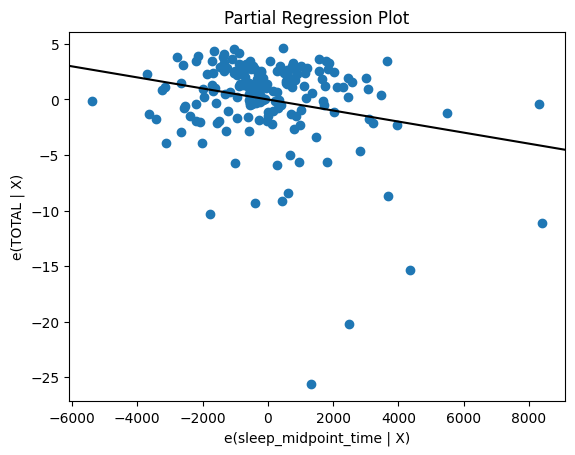

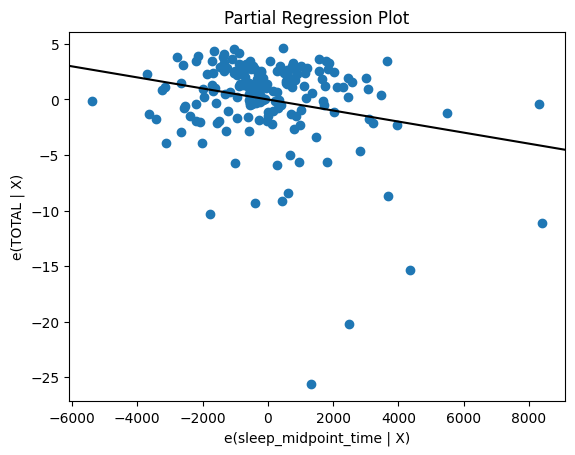

In [210]:
sm.graphics.plot_partregress('TOTAL', 'sleep_midpoint_time', ['sleep_onset_latency'], data = data_cleaned, obs_labels = False)

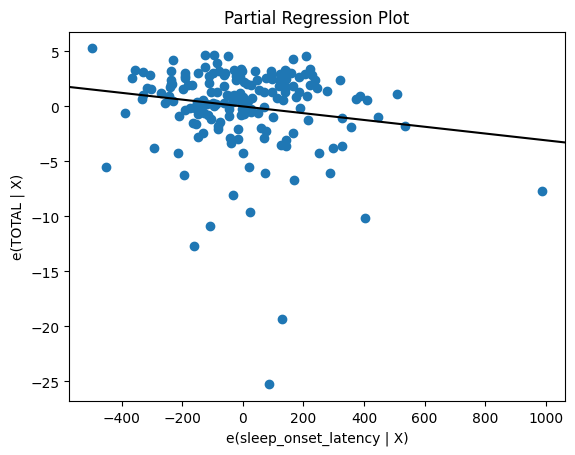

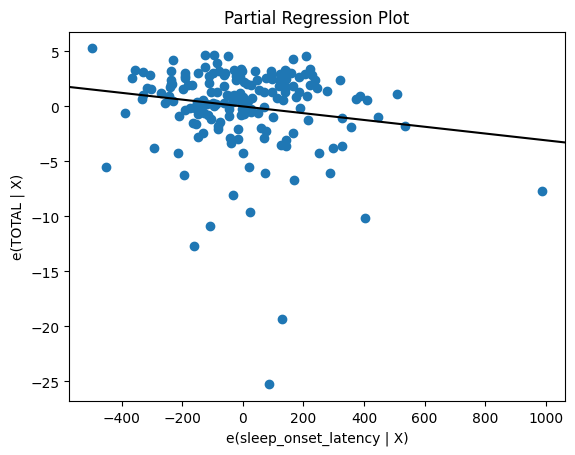

In [211]:
sm.graphics.plot_partregress('TOTAL', 'sleep_onset_latency', ['sleep_midpoint_time'], data = data_cleaned, obs_labels = False)